<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Stochastic dynamic systems </font></p>
<p></p>
<p><font size="5">  Notebook 01: Julia lab - Kalman and particle filters </font></p>
</p></br>
</p>
</CENTER>


----------------------------

# <span style="color:#00B8DE">I - Kalman filter (lab 1&2)</span>

Let 

$$
M_t=\sqrt{t}\begin{bmatrix}\cos(2\pi ft)\\ \sin(2\pi ft)\end{bmatrix}
$$

denote the trajectory of a point in a 2D space, with $t=1:T$. The corresponding speed will be calculated using backward finite difference. A noisy version of the trajectory and its speed are observed using a radar. The noise covariance matrix is in the form ${\bf \Sigma}_n=\sigma_n^2\mathbb{I}_4$. We model the system using a simple kinematic model in the form of a state space model where the state vector consists of the position, the speed and the acceleration of the point (as in the lesson). The acceleration is modeled by an $AR(1)$ process: $A_{t+1}=\rho A_t+v_{A,t}$ with ${\bf \Sigma}_{v_A}=\sigma_{v_A}^2\mathbb{I}_2$. We shall write the model 

$$
X_{t+1}={\bf F} X_t +{\bf G} v_t\\
Y_t = {\bf H} X_t+{\bf U} n_t
$$

>- 1) Plot the noiseless and noisy trajectories of position and speed with $T=200$;
>- 2) Give the expressions of ${\bf F}$ and ${\bf H}$ and give the expressions of the matrices ${\bf D}_Q$ and ${\bf D}_R$ in covariance matrices ${\bf Q}=cov[{\bf G} v_t]=σ_v^2 {\bf D}_Q$ and ${\bf R}=cov[{\bf U} n_t]=σ_n^2 {\bf D}_R$;
>- 3) Denoting by  ${\bf K}$, ${\bf P}\_$ and ${\bf P}$ the Kalman gain, and covariance matrices of prediction and filtering errors respectively implement the Kalman filter;
>- 4) Plot the trajectories of position and speed estimated using the Kalman filter. Check the robustness of the estimation with respect to the choice of the parameters of the model;
>- 5) Implement Kalman smoother and check the improvment brought compared to the Kalman filter.

In [53]:
#using LinearAlgebra 
#using Plots         
#using Distributions 

In [54]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import random as rd

In [55]:
## Define the parameters of the model
T = 200 # Number of time steps
f = 2/T # Frequency
delta = 1 # Lenght of step
time = np.arange(0, T, delta) # Timeline
sigma_v = np.sqrt(0.01) # Noise covariance for acceleration
sigma_n = np.sqrt(0.1) # Noise covariance for position
rho = 0.1 # AR(1) parameter

In [56]:
#--------------------------
# PART I : Kalman filter
#--------------------------
# Trajectory synthesis
#---------------------

# Define the x and y trajectories
def x(t):
    return np.sqrt(t)*np.cos(2*np.pi*f*t)

def y(t):
    return np.sqrt(t)*np.sin(2*np.pi*f*t)

# Noisiless trajectory
M = np.array([ [x(t), y(t)] for t in time])
X, Y = np.array([M[t][0] for t in time]), np.array([M[t][1] for t in time])
V = np.array([ [(M[t+1][0]-M[t][0]) /delta ,(M[t+1][1]-M[t][1]) /delta] for t in time[0:T-1]])
Vx, Vy = np.array([V[t][0] for t in time[0:T-1]]), np.array([V[t][1] for t in time[0:T-1]])

# Noisy trajectory / we assume difference in noise for x and y 
Mn = np.array([[M[t][0]+rd.gauss(0,sigma_n) , M[t][1]+rd.gauss(0, sigma_n)] for t in time])
Xn, Yn = np.array([Mn[t][0] for t in time]), np.array([Mn[t][1] for t in time])
Vn = np.array([((Mn[t+1][0]-Mn[t][0]) / delta ,(Mn[t+1][1]-Mn[t][1]) / delta) for t in time[0:T-1]])
Vnx, Vny = np.array([Vn[t][0] for t in time[0:T-1]]), np.array([Vn[t][1] for t in time[0:T-1]])


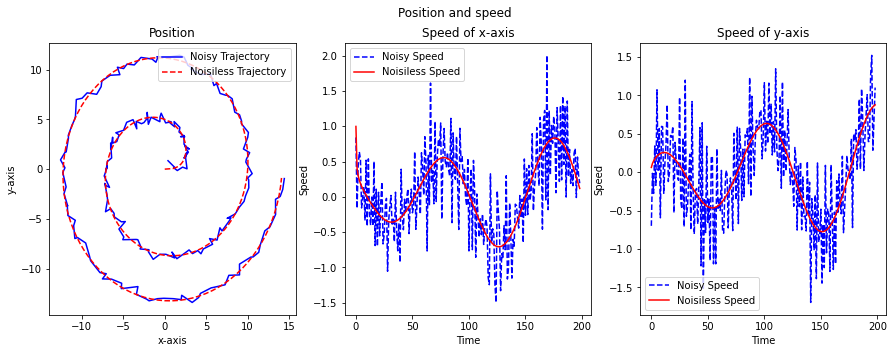

In [57]:
# Plotting the trajectories
plt.subplot(131)
plt.plot(Xn, Yn, "b", label = "Noisy Trajectory")
plt.plot(X, Y, "r--", label = "Noisiless Trajectory")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Position")
plt.legend(loc="upper right")

plt.subplot(132)
plt.plot(time[0:T-1], Vnx, "b--", label = "Noisy Speed")
plt.plot(time[0:T-1], Vx, "r", label = "Noisiless Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of x-axis")
plt.legend()

plt.subplot(133)
plt.plot(time[0:T-1], Vny, "b--", label = "Noisy Speed")
plt.plot(time[0:T-1], Vy, "r", label = "Noisiless Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of y-axis")
plt.legend()

plt.rcParams['figure.figsize'] = [15, 5] #size of plot
plt.suptitle("Position and speed")
plt.show()

We compare the Noisy trajectory with the noisiless one. They differ by the gaussian noise of $\sigma_v$ variance.
As seen, the speed is much more noised than the trajectory because the noisy trajectory is not continuous. To minimize the noise of the speeds, we could have chosen tinier steps to generate the trajectory.

In [58]:
# State space model
#------------------


def Kalman_filt(rho = 1, sigma_v = 0.0001, sigma_n = 0.01, delta = 1):
    
    # Defining the noisy trajectories
    Mn = np.array([[x(t)+rd.gauss(0,sigma_n) , y(t)+rd.gauss(0, sigma_n)] for t in time])
    Vn = np.array([((Mn[t+1][0]-Mn[t][0]) / delta ,(Mn[t+1][1]-Mn[t][1]) / delta) for t in time[0:T-1]])
    Vnx, Vny = np.array([Vn[t][0] for t in time[0:T-1]]), np.array([Vn[t][1] for t in time[0:T-1]])

    
    ## Defining constant for Kalman's equation

    # Define the state transition matrix F
    F = np.array([[rho, 0, 0, 0, 0, 0], [0, rho, 0, 0, 0, 0], [delta, 0, 1, 0, 0, 0], [0, delta, 0, 1, 0, 0], [0, 0, delta, 0, 1, 0], [0, 0, 0, delta, 0, 1]])

    # Define the noise matrix of acceleration
    def vt():
        return np.array([rd.gauss(0,sigma_v), rd.gauss(0,sigma_v), 0, 0, 0, 0])

    # Observation
    #------------

    # Define the measurement matrix H
    H = np.array([ [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1] ])

    # Define the noise matrix of measurement
    def nt():
        return np.array( [rd.gauss(0,sigma_n), rd.gauss(0,sigma_n), rd.gauss(0,sigma_n), rd.gauss(0,sigma_n)] )

    # Storage
    #--------

    # Initialize the state vector
    Xt = np.zeros(6) # Xt|t = (ax, ay, vx, vy, x, y)^T
    Xt_ = np.zeros(6) # Xt|t-1 = (ax, ay, vx, vy, x, y)^T

    # y : list of yt = (vx, vy, x, y)^T
    yt = np.array([np.array([Vnx[t], Vny[t], Xn[t], Yn[t]]) for t in time[:-1]])
    Yt = np.zeros((4,T))

    P = np.zeros(6) # Pt|t-1
    P_ = np.zeros(6) # Pt|t
    K = np.zeros(6)

    # Filtering
    #----------

    # Define the covariance matrix
    D_Q = np.zeros((6,6))
    D_Q[0,0], D_Q[1,1] = 1, 1 
    D_R = np.eye(4)

    R = sigma_n**2*D_R
    Q = sigma_v**2*D_Q


    for t in time :
        Yt[:,t] = Xt[2:]

        Xt_ = np.dot(F, Xt)
        P_ = np.dot(F,np.dot(P,F.T)) + Q
        K = np.dot(P_, np.dot(H.T, np.linalg.inv(np.dot(H,np.dot(P_,H.T)) + R)))
        Xt = Xt_ + np.dot(K,yt[t-1,:] - np.dot(H, Xt_) )
        P = P_ - np.dot(K,np.dot(H,P_))

    return Yt

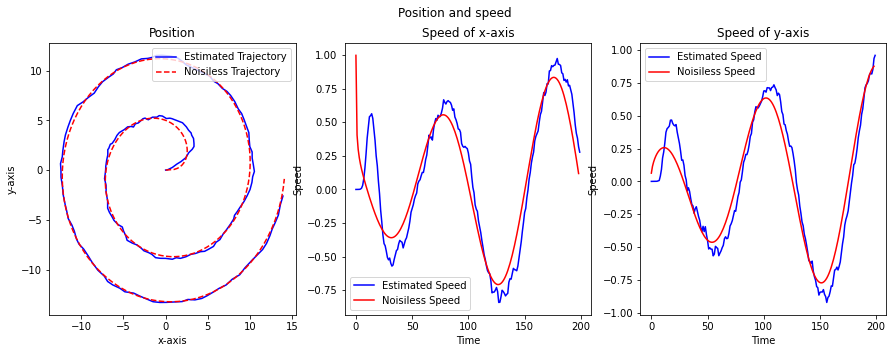

In [59]:
# Graphic outputs
#----------------

Yt = Kalman_filt()

plt.subplot(131)
plt.plot(Yt[2,:], Yt[3,:], "b", label = "Estimated Trajectory")
plt.plot(X, Y, "r--", label = "Noisiless Trajectory")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Position")
plt.legend(loc="upper right")

plt.subplot(132)
plt.plot(Yt[0,:], "b", label = "Estimated Speed")
plt.plot(Vx, "r", label = "Noisiless Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of x-axis")
plt.legend()

plt.subplot(133)
plt.plot(Yt[1,:], "b", label = "Estimated Speed")
plt.plot(Vy, "r", label = "Noisiless Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of y-axis")
plt.legend()

plt.rcParams['figure.figsize'] = [15, 5] #size of plot
plt.suptitle("Position and speed")

plt.show()

We compare the exact trajectory with an estimated one with parameters : $\rho = 1$, $\sigma_v = 0.0001$, $\sigma_n = 0.01$, $\Delta = 1$.
As we can see on the plot, the main difference is on the one hand the lag in the speed between both graphics, and on the other hand the noise on the heap of the functions.
The main problem is nevertheless the beginning of the speeds as they don't start at 0 on the contrary of the estimation. Moreover, the speed on the x-axis starts at the infinite which is hard to handle for the estimation method we use.

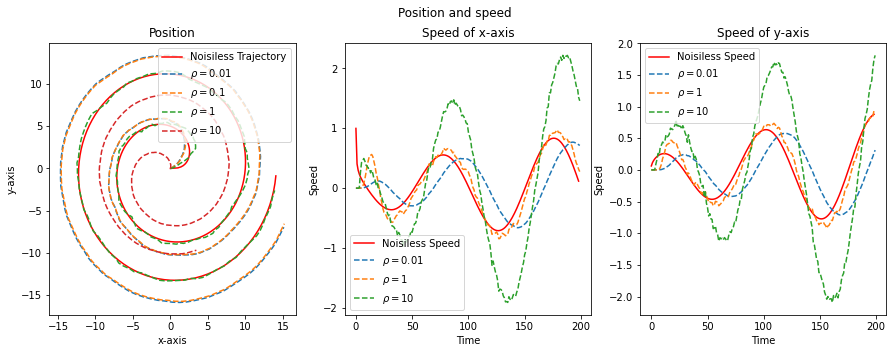

In [60]:
# Robustness
#-----------

# Rho
r6 = Kalman_filt(0.001)
r1 = Kalman_filt(0.01)
r2 = Kalman_filt(0.1)
r3 = Kalman_filt(1)
r4 = Kalman_filt(3)
r5 = Kalman_filt(10)
r7 = Kalman_filt(100)

plt.subplot(131)
plt.plot(X, Y,'r', label = r"Noisiless Trajectory")
#plt.plot(r6[2,:], r6[3,:],'g--', label = r'$\rho = 0.001$')
plt.plot(r1[2,:], r1[3,:],'--', label = r'$\rho = 0.01$')
plt.plot(r2[2,:], r2[3,:],'--', label = r'$\rho = 0.1$')
plt.plot(r3[2,:], r3[3,:],'--', label = r'$\rho = 1$')
#plt.plot(r4[2,:], r4[3,:],'--', label = r'$\rho = 3$')
plt.plot(r5[2,:], r5[3,:],'--', label = r'$\rho = 10$')
#plt.plot(r7[2,:], r7[3,:],'--', label = r'$\rho = 100$')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Position")
plt.legend()

plt.subplot(132)
plt.plot(Vx,'r', label = r"Noisiless Speed")
plt.plot(r1[0,:],'--', label = r'$\rho = 0.01$')
plt.plot(r3[0,:],'--', label = r'$\rho = 1$')
plt.plot(r5[0,:],'--', label = r'$\rho = 10$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of x-axis")
plt.legend()

plt.subplot(133)
plt.plot(Vy,'r', label = r"Noisiless Speed")
plt.plot(r1[1,:],'--', label = r'$\rho = 0.01$')
plt.plot(r3[1,:],'--', label = r'$\rho = 1$')
plt.plot(r5[1,:],'--', label = r'$\rho = 10$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of y-axis")
plt.legend()

plt.rcParams['figure.figsize'] = [15,5] #size of plot
plt.suptitle("Position and speed")

plt.show()

In this part of the lab, we compare the robustness of the algorithm based on the $\rho$ parameter.
The effect of $\rho$ are different depending on the component we study. As for the trajectory, $\rho$ must be close to 1 to be effective and minimize the standard deviation. We assume that this conclusion is also valid once looking the speed. Nevertheless, there is a lag between the exact trajectory and the estimated one.

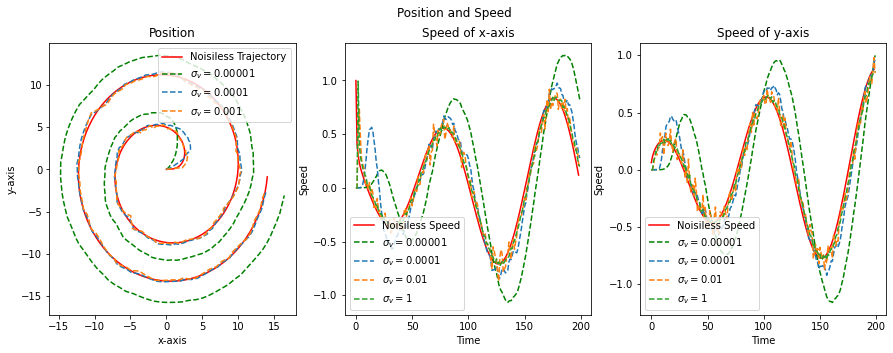

In [61]:
# sigma_v
r6 = Kalman_filt(1,0.00001)
r1 = Kalman_filt(1,0.0001)
r2 = Kalman_filt(1,0.001)
r3 = Kalman_filt(1,0.01)
r4 = Kalman_filt(1,0.1)
r5 = Kalman_filt(1,1)
r7 = Kalman_filt(1,10)

plt.subplot(131)
plt.plot(X, Y,'r', label = r"Noisiless Trajectory")
plt.plot(r6[2,:], r6[3,:],'g--', label = r'$\sigma_v = 0.00001$')
plt.plot(r1[2,:], r1[3,:],'--', label = r'$\sigma_v = 0.0001$')
plt.plot(r2[2,:], r2[3,:],'--', label = r'$\sigma_v = 0.001$')
#plt.plot(r3[2,:], r3[3,:],'--', label = r'$\sigma_v = 0.01$')
#plt.plot(r4[2,:], r4[3,:],'--', label = r'$\sigma_v = 0.1$')
#plt.plot(r5[2,:], r5[3,:],'--', label = r'$\sigma_v = 1$')
#plt.plot(r7[2,:], r7[3,:],'--', label = r'$\sigma_v = 10$')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Position")
plt.legend()

plt.subplot(132)
plt.plot(Vx,'r', label = r"Noisiless Speed")
plt.plot(r6[0,:],'g--', label = r'$\sigma_v = 0.00001$')
plt.plot(r1[0,:],'--', label = r'$\sigma_v = 0.0001$')
plt.plot(r3[0,:],'--', label = r'$\sigma_v = 0.01$')
plt.plot(r5[0,:],'--', label = r'$\sigma_v = 1$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of x-axis")
plt.legend()

plt.subplot(133)
plt.plot(Vy,'r', label = r"Noisiless Speed")
plt.plot(r6[1,:],'g--', label = r'$\sigma_v = 0.00001$')
plt.plot(r1[1,:],'--', label = r'$\sigma_v = 0.0001$')
plt.plot(r3[1,:],'--', label = r'$\sigma_v = 0.01$')
plt.plot(r5[1,:],'--', label = r'$\sigma_v = 1$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of y-axis")
plt.legend()

plt.rcParams['figure.figsize'] = [15,5] #size of plot
plt.suptitle("Position and Speed")

plt.show()

As we can on these plots, the smaller the $\sigma_v$, the more noised the estimation is. Furthermoe, with a too big $\sigma_v$ the estimation doesn't fit the noisiless trajectory.
As we defined the matrix ${\bf F}$, ${\bf G}$, ${\bf H}$ and ${\bf U}$, the use $\sigma_n$ only affects the acceleration which is partially used to define what is plotted here.

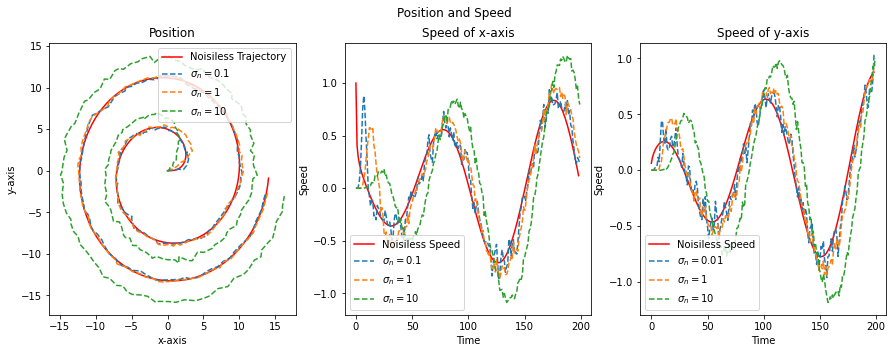

In [62]:
# sigma_n
r6 = Kalman_filt(1,0.001,0.00001)
r1 = Kalman_filt(1,0.001,0.0001)
r2 = Kalman_filt(1,0.001,0.001)
r3 = Kalman_filt(1,0.001,0.01)
r4 = Kalman_filt(1,0.01,0.1)
r5 = Kalman_filt(1,0.01,1)
r7 = Kalman_filt(1,0.01,10)


plt.subplot(131)
plt.plot(X, Y,'r', label = r"Noisiless Trajectory")
plt.plot(r4[2,:], r4[3,:],'--', label = r'$\sigma_n = 0.1$')
plt.plot(r5[2,:], r5[3,:],'--', label = r'$\sigma_n = 1$')
plt.plot(r7[2,:], r7[3,:],'--', label = r'$\sigma_n = 10$')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Position")
plt.legend()

plt.subplot(132)
plt.plot(Vx,'r', label = r"Noisiless Speed")
plt.plot(r4[0,:],'--', label = r'$\sigma_n = 0.1$')
plt.plot(r5[0,:],'--', label = r'$\sigma_n = 1$')
plt.plot(r7[0,:],'--', label = r'$\sigma_n = 10$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of x-axis")
plt.legend()

plt.subplot(133)
plt.plot(Vy,'r', label = r"Noisiless Speed")
plt.plot(r4[1,:],'--', label = r'$\sigma_n = 0.01$')
plt.plot(r5[1,:],'--', label = r'$\sigma_n = 1$')
plt.plot(r7[1,:],'--', label = r'$\sigma_n = 10$')
plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Speed of y-axis")
plt.legend()

plt.rcParams['figure.figsize'] = [15,5] #size of plot
plt.suptitle("Position and Speed")

plt.show()

Here, the noise $\sigma_n$ is much more present because it affects directly the computing of the trajectory and speeds.

# <span style="color:#00B8DE">II - Particle filtering (lab 3)</span>

We consider the following nonlinear system:

$$
\begin{array}{lll}
{\text{state: }} &x_{t+1} &= 0.5 x_t + \dfrac{25x_t}{1+x_t^2}+8\cos(1,2t)+ v_t,\\
{\text{observation: }} &y_t &= 0.05 x_t^2+ w_t,
\end{array}
$$

with $v_t$ and $w_t$ having respective distributions $\mathcal{N}(0,0.1)$ and $\mathcal{N}(0,1)$.
We want to estimate recursively the state of the system by using a bootstrap particle filter.
We shall use 100 particles and choose $N_{eff}=90$.

>- 1) Generate a trajectory of $y$ for $t=1:T$ with $T=100$. Plot it as well as the corresponding trajectory of x.
What do we note ? For the model studied here what is the main difficulty met in estimating $x$ from $y$?
>- 2) Simulate $N=10^3$ particles using $p(x_t|x_{t-1}^{(i)})$ as an importance distribution and implement the code for generating particles, calculating weights and normalized weights. Implement resampling and apply it when $N_{eff}<90\% N$. What is the resampling rate ?
>- 3) What occurs as the state noise variance increases ? Explanations ?
>- 4) Possibly test the code with other noise distributions

In [63]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import random as rd

In [64]:
## Defining the constants
T = 100
delta = 1
time = np.arange(0, T, delta)
sig_v, sig_w = np.sqrt(0.1), np.sqrt(1)
N = 10**3
thr = 0.9
N_p, N_eff = 100, thr*N

In [65]:
#-----------------------------
# 1) Data model and generation
#-----------------------------

## Generating the trajectories
def x_t1(x,t):
    return 0.5*x + 25*x/(1+x**2) + 8*np.cos(1.2*t) + rd.gauss(0,sig_v)

def y_t(x):
    return 0.05*x**2 + rd.gauss(0, sig_w)

def gen_X():
    X = np.zeros(T)
    for t in time[1:T]:
        X[t] = x_t1(X[t-1],t-1)
    return X

def gen_Y(X):
    return [y_t(X[t]) for t in time]

x = gen_X()
y = gen_Y(x)

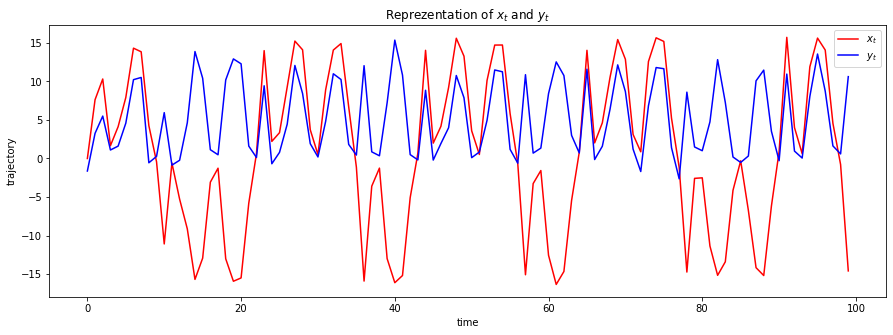

In [66]:
# Graphic outputs
#----------------

plt.plot(x, "r", label=r"$x_t$")
plt.plot(y,"b", label=r"$y_t$")
plt.xlabel("time")
plt.ylabel("trajectory")

plt.legend()
plt.title(r"Reprezentation of $x_t$ and $y_t$")
plt.rcParams['figure.figsize'] = [15, 5] #size of plot
plt.show()

As expected, x is not linear and both functions are almost periodical.
The noise and lack of linearity of $y_t$ from $x_t$ makes it hard for us to estimate the initial function.

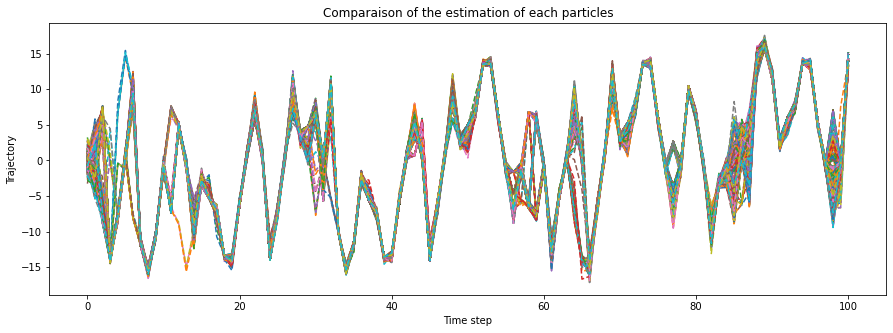

In [67]:
#--------------------------
# 2) Particle sampling
#--------------------------
# Particles initialization
#--------------------------

sigma_v = np.sqrt(0.1)
sigma_w = np.sqrt(1)
threshold = 0.9
N = 10**3
T = 100
resampling_rate = 0

x0 = np.random.randn(N)
particles = x0
weights = np.ones(N)/N

x_est = np.zeros(T+1)
x_est[0] = np.mean(x0)

particle_trajectories = np.zeros((N, T+1))
particle_trajectories[:,0] = x0

#--------------------------
# Particles sampling
#--------------------------

for t in range(1, T+1):
    next_x = 0.5*particles + 25*particles/(1+particles**2) + 8*np.cos(1.2*t) + np.random.normal(0,sigma_v,size=N)
    particles = next_x
        
    weights = weights * np.exp(-0.5 * (y[t-1] - 0.05*particles**2)**2 / sigma_w)
    weights = weights / np.sum(weights)
            
    Neff = 1 / np.sum(weights**2)
    if Neff < threshold*N:
        resampling_rate += 1
        particles = np.random.choice(particles, size=N, p=weights)
        weights = np.ones(N) / N
        
    x_est[t] = np.sum(particles * weights, axis=0)
    particle_trajectories[:,t] = particles

resampling_rate = resampling_rate / T

#--------------------------
# Graphic output
#--------------------------

for i in range(particle_trajectories.shape[0]):
    plt.plot(particle_trajectories[i, :], '--')

plt.title("Comparaison of the estimation of each particles")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.show()

We see that the particles tend to have the same behavior. There are semi periodically times for which the particles are chaotic and the rest of the time the particles have the same trajectory.
There are too many particles, let's see some of them.

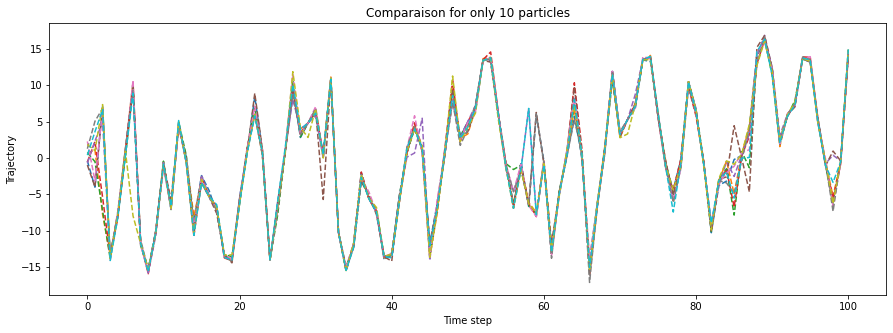

In [68]:
for i in range(10):
    plt.plot(particle_trajectories[i, :], '--')

plt.title("Comparaison for only 10 particles")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.show()

We might want to know the ressempling rate :

In [69]:
print("Resampling rate is equal to :", resampling_rate*100,"%")

Resampling rate is equal to : 83.0 %


We can see that all the particles are very similar to each others and very similar to the true value of x ploted above. This can be explained by the fact that the resampling rate is almost equal to 75-80 % so it is almost like if there is a resample step every 4-5 time step.

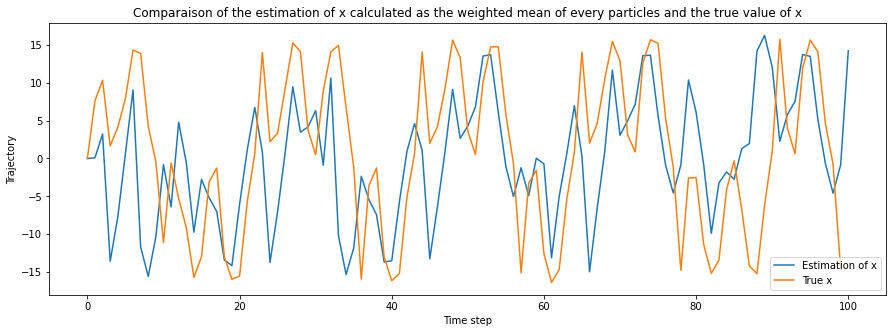

In [70]:
plt.plot(range(x_est.size), x_est, label="Estimation of x")
plt.plot(x, label="True x")
plt.title("Comparaison of the estimation of x calculated as the weighted mean of every particles and the true value of x")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.legend()
plt.show()

Mean of the error is equal to 103.62


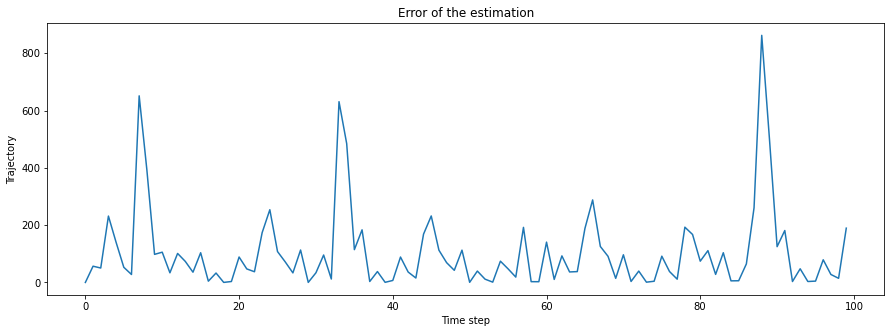

In [71]:
#--------------------------
# Error
#--------------------------

error = np.absolute((x_est[:-1]-x)**2)
print("Mean of the error is equal to", round(np.mean(error),3))

plt.plot(range(error.size), error)
plt.title("Error of the estimation")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.show()

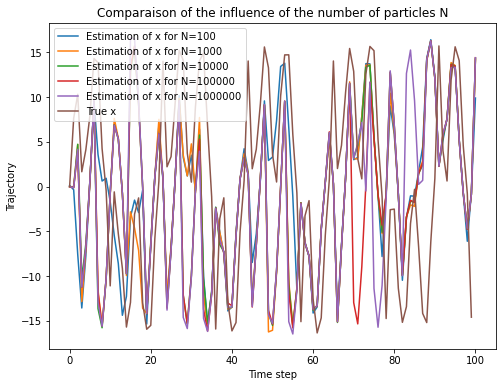

In [72]:
sigma_v = np.sqrt(0.1)
sigma_w = np.sqrt(1)
threshold = 0.9
N_list = [10**2,10**3,10**4,10**5,10**6]
T = 100
resampling_rate = 0

#--------------------------
# Particles sampling
#--------------------------
plt.figure(figsize=(8, 6))

for N in N_list:

    x0 = np.random.randn(N)
    particles = x0
    weights = np.ones(N)/N

    x_est = np.zeros(T+1)
    x_est[0] = np.mean(x0)

    particle_trajectories = np.zeros((N, T+1))
    particle_trajectories[:,0] = x0


    for t in range(1, T+1):
        next_x = 0.5*particles + 25*particles/(1+particles**2) + 8*np.cos(1.2*t) + np.random.normal(0,sigma_v,size=N)
        particles = next_x
            
        weights = weights * np.exp(-0.5 * (y[t-1] - 0.05*particles**2)**2 / sigma_w)
        weights = weights / np.sum(weights)
                
        Neff = 1 / np.sum(weights**2)
        if Neff < threshold*N:
            resampling_rate += 1
            particles = np.random.choice(particles, size=N, p=weights)
            weights = np.ones(N) / N
            
        x_est[t] = np.sum(particles * weights, axis=0)
        particle_trajectories[:,t] = particles

    resampling_rate = resampling_rate / T

    plt.plot(range(x_est.size), x_est, label="Estimation of x for N={}".format(N))

plt.plot(x, label="True x")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.title("Comparaison of the influence of the number of particles N")
plt.legend(loc="upper left")
plt.show()

We can see that in this case the number of particles does not have an important impact on the accuracy of the estimation.

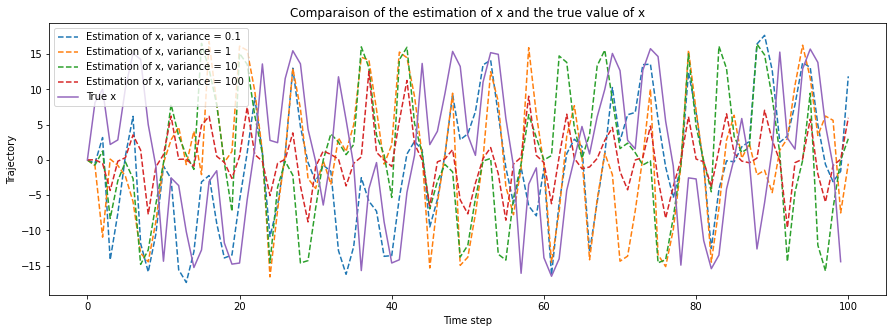

In [73]:
#-------------------------------------------------------
# 3) What occurs as the state noise variance increases ?
#-------------------------------------------------------

for sigma_v2 in [0.1,1,10,100]:
    x = gen_X()
    y = gen_Y(x)
    #x, y = trajectories(sigma_v=np.sqrt(0.1))

    sigma_v = np.sqrt(sigma_v2)
    sigma_w = np.sqrt(1)
    threshold = 0.9
    N = 10**3
    T = 100
    resampling_rate = 0

    x0 = np.random.randn(N)
    particles = x0
    weights = np.ones(N)/N

    x_est = np.zeros(T+1)
    x_est[0] = np.mean(x0)

    particle_trajectories = np.zeros((N, T+1))
    particle_trajectories[:,0] = x0

    for t in range(1, T+1):
        next_x = 0.5*particles + 25*particles/(1+particles**2) + 8*np.cos(1.2*t) + np.random.normal(0,sigma_v,size=N)
        particles = next_x
            
        weights = weights * np.exp(-0.5 * (y[t-1] - 0.05*particles**2)**2 / sigma_w)
        weights = weights / np.sum(weights)
                
        Neff = 1 / np.sum(weights**2)
        if Neff < threshold*N:
            resampling_rate += 1
            particles = np.random.choice(particles, size=N, p=weights)
            weights = np.ones(N) / N
            
        x_est[t] = np.sum(particles * weights, axis=0)
        particle_trajectories[:,t] = particles

    resampling_rate = resampling_rate / T

    plt.plot(range(x_est.size), x_est, '--',label=f"Estimation of x, variance = {sigma_v2}")

plt.plot(x, label="True x")
plt.title("Comparaison of the estimation of x and the true value of x")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.legend(loc="upper left")
plt.show()

We can see that the estimation goes further from the true value of the x trajectory as the state noise variance increases. So it's harder to estimate x based on y.

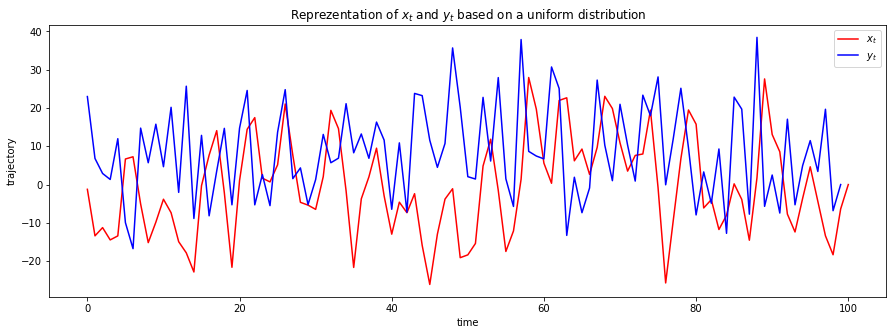

In [74]:
#---------------------------------------------------------
# 4) Possibly test the code with other noise distributions
#---------------------------------------------------------
    
x = np.zeros(T+1)
y = np.zeros(T)

x[0] = np.random.randn()

for t in range(1, T):
    next_x = 0.5*x[t-1] + 25*x[t-1]/(1+x[t-1]**2) + 8*np.cos(1.2*t) + np.random.uniform(-10,10)
    y_t = 0.05*next_x**2 + np.random.normal(0,sigma_v)
    x[t] = next_x
    y[t-1] = y_t

sigma_v = 0.5
sigma_w = 1
threshold = 0.9
N = 10**3
T = 100

x0 = np.random.randn(N)
particles = x0
weights = np.ones(N)/N

x_est = np.zeros(T+1)
x_est[0] = np.mean(x0)

for t in range(1, T+1):
    next_x = 0.5*particles + 25*particles/(1+particles**2) + 8*np.cos(1.2*t) + np.random.uniform(-1,1,size=N)
    particles = next_x
        
    weights = weights * np.exp(-0.5 * (y[t-1] - 0.05*particles**2)**2 / sigma_w)
    weights = weights / np.sum(weights)
            
    Neff = 1 / np.sum(weights**2)
    if Neff < threshold*N:
        particles = np.random.choice(particles, size=N, p=weights)
        weights = np.ones(N) / N
        
    x_est[t] = np.sum(particles * weights, axis=0)

# Graphic outputs
#----------------

plt.plot(x, "r", label=r"$x_t$")
plt.plot(y,"b", label=r"$y_t$")
plt.xlabel("time")
plt.ylabel("trajectory")

plt.legend()
plt.title(r"Reprezentation of $x_t$ and $y_t$ based on a uniform distribution")
plt.rcParams['figure.figsize'] = [15, 5] #size of plot
plt.show()


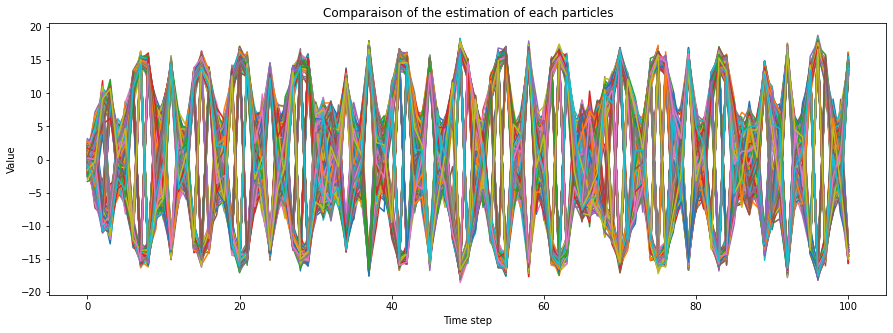

In [75]:
for i in range(particle_trajectories.shape[0]):
    plt.plot(particle_trajectories[i, :])

plt.title("Comparaison of the estimation of each particles")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()

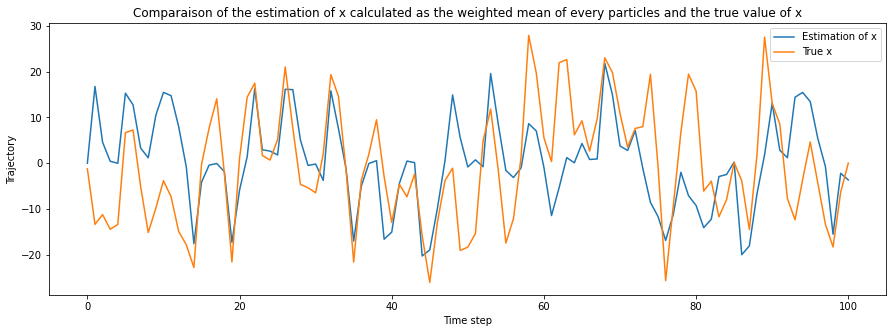

In [76]:
plt.plot(x_est, label="Estimation of x")
plt.plot(x, label="True x")
plt.title("Comparaison of the estimation of x calculated as the weighted mean of every particles and the true value of x")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.legend()
plt.show()

We can see that when we change the gaussian distribution of the state noise for a uniform distribution between -10 and 10, we have some very different particles at the end of the filtering. However, we obtain an estimation that is not too far from the true value. 

Mean of the error is equal to 147.188


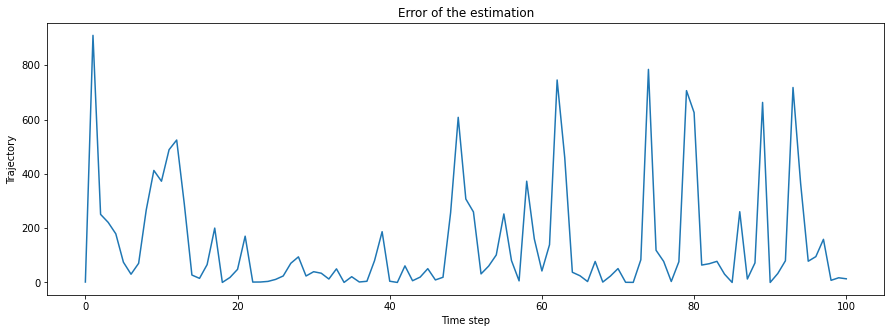

In [77]:
#------
# Error
#------

error = np.absolute((x_est-x)**2)
print("Mean of the error is equal to", round(np.mean(error),3))

plt.plot(range(error.size), error)
plt.title("Error of the estimation")
plt.xlabel("Time step")
plt.ylabel("Trajectory")
plt.show()

We see approximetaly the same results as when using a normal distribution.